# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
import random

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

RAND_SEED = 0

## EDA

In [2]:
# Read the CSV file
df = pd.read_csv("Var_1_BreadBasket_DMS.csv")

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by 'Transaction' and 'Date'
df.sort_values(['Transaction', 'Date'], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Remove rows where 'Item' is 'Adjustment' or 'NONE'
df = df[~df['Item'].isin(['Adjustment', 'NONE'])]

# Convert dataframe to list of lists for TransactionEncoder
transactions = df.groupby(['Transaction'])['Item'].apply(list).values.tolist()

# Encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

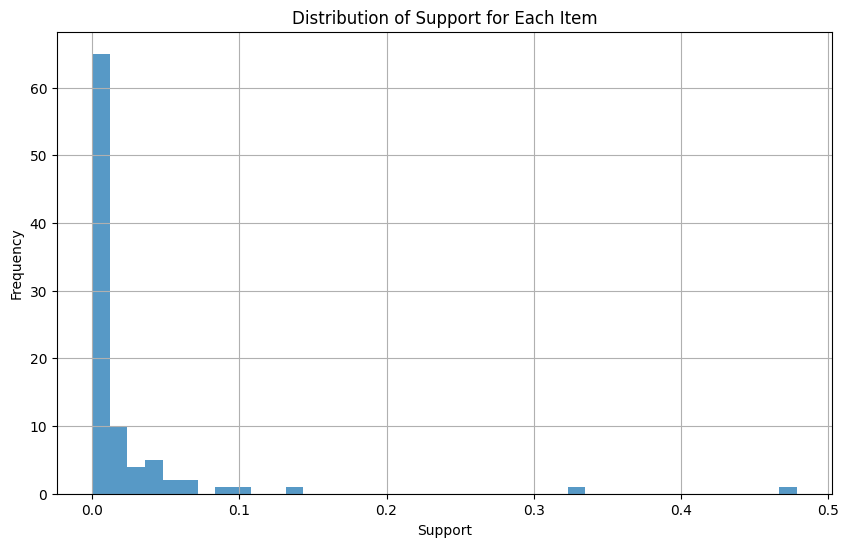

In [3]:
# Calculate support for each item
item_supports = df_encoded.mean()

# Plot the distribution of support
plt.figure(figsize=(10, 6))
plt.hist(item_supports, bins=40, alpha=0.75)
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.title('Distribution of Support for Each Item')
plt.grid(True)
plt.show()

In [4]:
# Convert item_supports to a DataFrame and reset the index
item_supports_df = item_supports.reset_index()

# Rename the columns
item_supports_df.columns = ['Item', 'Support']
item_supports_sorted = item_supports_df.iloc[np.argsort(item_supports_df['Support'])[::-1]]
# Print the DataFrame
item_supports_sorted

,Item,Support
22,Coffee,0.478445
10,Bread,0.327240
82,Tea,0.142646
14,Cake,0.103867
64,Pastry,0.086116
...,...,...
70,Raw bars,0.000106
4,Bacon,0.000106
18,Chicken sand,0.000106
83,The BART,0.000106


# Apriori
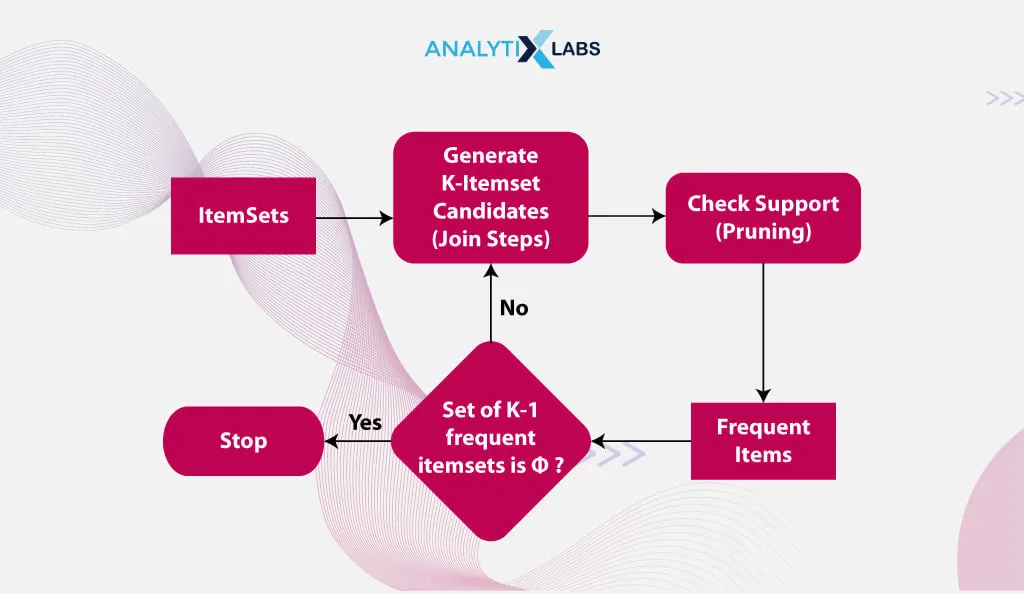
# FPGrowth
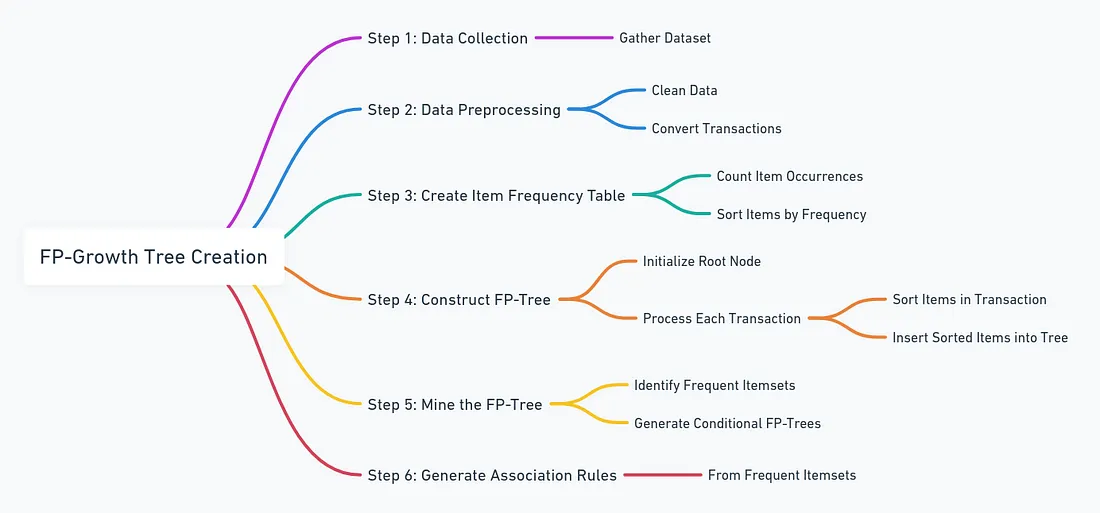

### Method for significant rules hyperparameters search

In [16]:
def dm_grid_search(algorithm):
    # Define ranges for the parameters
    min_support_range = [1e-3, 5e-3, 1e-2, 0.1]
    min_confidence_range = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    max_len_range = [2, 3, 4, 5]

    # Initialize a list to store parameters that lead to significant rules
    significant_parameters = []
    res_df = pd.DataFrame(columns=['min_support', 'min_confidence', 'max_len', 'num_rules', 'num_significant_rules'])
    
    # Loop through the combinations of parameters
    for min_support in min_support_range:
        for min_confidence in min_confidence_range:
            for max_len in max_len_range:
                # Generate frequent itemsets
                frequent_itemsets = algorithm(df_encoded, min_support=min_support, use_colnames=True, max_len=max_len)

                # Generate association rules
                rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

                # Filter rules by lift
                significant_rules = rules[rules['lift'] > 1]

                # If there are any significant rules, save the parameters
                if len(significant_rules) > 0:
                    significant_parameters.append((min_support, min_confidence, max_len, len(significant_rules)))

                # Output information about the rules
                print(f"min_support: {min_support}, min_confidence: {min_confidence}, max_len: {max_len}")
                print(f"Number of rules: {len(rules)}")
                print(f"Number of significant rules: {len(significant_rules)}\n")
                
                # Append the results to the DataFrame
                new_row = pd.DataFrame({
                    'min_support': [min_support],
                    'min_confidence': [min_confidence],
                    'max_len': [max_len],
                    'num_rules': [len(rules)],
                    'num_significant_rules': [len(significant_rules)]
                })
                res_df = pd.concat([res_df, new_row], ignore_index=True)

    significant_parameters = np.array(significant_parameters)
    best_params = significant_parameters[significant_parameters[:, 3] == np.max(significant_parameters[significant_parameters[:, 1] >= 0.5][:, 3])]
    print(f"-----\nParameters that led to the biggest amount of significant rules ({int(best_params[0][3])}):")
    for params in best_params:
        print(f"min_support: {params[0]}, min_confidence: {params[1]}, max_len: {int(params[2])}")

    return best_params, res_df

## Apriori
### Best hyperparameters

In [17]:
best_params_apriori, results_df_apriori = dm_grid_search(apriori)

min_support: 0.001, min_confidence: 0.2, max_len: 2
Number of rules: 83
Number of significant rules: 50



C:\Users\Oleksiy\AppData\Local\Temp\ipykernel_3668\1899854523.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, new_row], ignore_index=True)


min_support: 0.001, min_confidence: 0.2, max_len: 3
Number of rules: 284
Number of significant rules: 174

min_support: 0.001, min_confidence: 0.2, max_len: 4
Number of rules: 291
Number of significant rules: 177

min_support: 0.001, min_confidence: 0.2, max_len: 5
Number of rules: 291
Number of significant rules: 177

min_support: 0.001, min_confidence: 0.3, max_len: 2
Number of rules: 42
Number of significant rules: 34

min_support: 0.001, min_confidence: 0.3, max_len: 3
Number of rules: 176
Number of significant rules: 126

min_support: 0.001, min_confidence: 0.3, max_len: 4
Number of rules: 179
Number of significant rules: 128

min_support: 0.001, min_confidence: 0.3, max_len: 5
Number of rules: 179
Number of significant rules: 128

min_support: 0.001, min_confidence: 0.4, max_len: 2
Number of rules: 30
Number of significant rules: 29

min_support: 0.001, min_confidence: 0.4, max_len: 3
Number of rules: 131
Number of significant rules: 107

min_support: 0.001, min_confidence: 0.4, 

In [18]:
results_df_apriori

,min_support,min_confidence,max_len,num_rules,num_significant_rules
0,0.001,0.2,2,83,50
1,0.001,0.2,3,284,174
2,0.001,0.2,4,291,177
3,0.001,0.2,5,291,177
4,0.001,0.3,2,42,34
...,...,...,...,...,...
91,0.100,0.6,5,0,0
92,0.100,0.7,2,0,0
93,0.100,0.7,3,0,0
94,0.100,0.7,4,0,0


### Frequent itemsets and significant association rules

In [19]:
frequent_itemsets_apriori = apriori(
    df_encoded, min_support=best_params_apriori[0][0], use_colnames=True, max_len=int(best_params_apriori[0][2])
    )
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=best_params_apriori[0][1])
rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Alfajores),(Coffee),0.036348,0.478445,0.019653,0.540698,1.130115,0.002263,1.135538,0.119477
1,(Art Tray),(Coffee),0.004015,0.478445,0.002747,0.684211,1.430073,0.000826,1.651592,0.301947
2,(Bakewell),(Coffee),0.005072,0.478445,0.003064,0.604167,1.262772,0.000638,1.317614,0.209152
3,(Eggs),(Bread),0.002959,0.327240,0.001479,0.500000,1.527930,0.000511,1.345520,0.346545
4,(Cake),(Coffee),0.103867,0.478445,0.054734,0.526958,1.101399,0.005039,1.102557,0.102734
...,...,...,...,...,...,...,...,...,...,...
91,"(Sandwich, Spanish Brunch)",(Coffee),0.001902,0.478445,0.001268,0.666667,1.393404,0.000358,1.564666,0.282871
92,"(Sandwich, Truffles)",(Coffee),0.003804,0.478445,0.002113,0.555556,1.161170,0.000293,1.173500,0.139330
93,"(Tea, Toast)",(Coffee),0.006445,0.478445,0.003276,0.508197,1.062185,0.000192,1.060496,0.058924
94,"(Bread, Pastry, Hot chocolate)",(Coffee),0.001585,0.478445,0.001057,0.666667,1.393404,0.000298,1.564666,0.282781


## FPGrowth
### Best hyperparameters

In [20]:
best_params_fpg, results_df_fpg = dm_grid_search(fpgrowth)

min_support: 0.001, min_confidence: 0.2, max_len: 2
Number of rules: 83
Number of significant rules: 50

min_support: 0.001, min_confidence: 0.2, max_len: 3
Number of rules: 284
Number of significant rules: 174

min_support: 0.001, min_confidence: 0.2, max_len: 4
Number of rules: 291
Number of significant rules: 177

min_support: 0.001, min_confidence: 0.2, max_len: 5
Number of rules: 291
Number of significant rules: 177

min_support: 0.001, min_confidence: 0.3, max_len: 2
Number of rules: 42
Number of significant rules: 34



C:\Users\Oleksiy\AppData\Local\Temp\ipykernel_3668\1899854523.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, new_row], ignore_index=True)


min_support: 0.001, min_confidence: 0.3, max_len: 3
Number of rules: 176
Number of significant rules: 126

min_support: 0.001, min_confidence: 0.3, max_len: 4
Number of rules: 179
Number of significant rules: 128

min_support: 0.001, min_confidence: 0.3, max_len: 5
Number of rules: 179
Number of significant rules: 128

min_support: 0.001, min_confidence: 0.4, max_len: 2
Number of rules: 30
Number of significant rules: 29

min_support: 0.001, min_confidence: 0.4, max_len: 3
Number of rules: 131
Number of significant rules: 107

min_support: 0.001, min_confidence: 0.4, max_len: 4
Number of rules: 134
Number of significant rules: 109

min_support: 0.001, min_confidence: 0.4, max_len: 5
Number of rules: 134
Number of significant rules: 109

min_support: 0.001, min_confidence: 0.5, max_len: 2
Number of rules: 25
Number of significant rules: 25

min_support: 0.001, min_confidence: 0.5, max_len: 3
Number of rules: 94
Number of significant rules: 94

min_support: 0.001, min_confidence: 0.5, ma

In [21]:
results_df_fpg

,min_support,min_confidence,max_len,num_rules,num_significant_rules
0,0.001,0.2,2,83,50
1,0.001,0.2,3,284,174
2,0.001,0.2,4,291,177
3,0.001,0.2,5,291,177
4,0.001,0.3,2,42,34
...,...,...,...,...,...
91,0.100,0.6,5,0,0
92,0.100,0.7,2,0,0
93,0.100,0.7,3,0,0
94,0.100,0.7,4,0,0


### Frequent itemsets and significant association rules

In [22]:
frequent_itemsets_fpg = fpgrowth(df_encoded, min_support=best_params_fpg[0][0], use_colnames=True, max_len=int(best_params_fpg[0][2]))
rules_fpg = association_rules(frequent_itemsets_fpg, metric="confidence", min_threshold=best_params_fpg[0][1])
rules_fpg

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Hot chocolate),(Coffee),0.058326,0.478445,0.029586,0.507246,1.060199,0.001680,1.058451,0.060298
1,"(Medialuna, Hot chocolate)",(Coffee),0.004755,0.478445,0.003064,0.644444,1.346957,0.000789,1.466874,0.258817
2,"(Cake, Hot chocolate)",(Coffee),0.011412,0.478445,0.006868,0.601852,1.257934,0.001408,1.309953,0.207413
3,"(Pastry, Hot chocolate)",(Coffee),0.005706,0.478445,0.003804,0.666667,1.393404,0.001074,1.564666,0.283953
4,"(Bread, Pastry, Hot chocolate)",(Coffee),0.001585,0.478445,0.001057,0.666667,1.393404,0.000298,1.564666,0.282781
...,...,...,...,...,...,...,...,...,...,...
91,"(Spanish Brunch, Bread)",(Coffee),0.004755,0.478445,0.002430,0.511111,1.068276,0.000155,1.066818,0.064218
92,"(Spanish Brunch, Cake)",(Coffee),0.002325,0.478445,0.001268,0.545455,1.140058,0.000156,1.147422,0.123138
93,"(Spanish Brunch, Juice)",(Coffee),0.002747,0.478445,0.002008,0.730769,1.527385,0.000693,1.937206,0.346237
94,(Extra Salami or Feta),(Coffee),0.004015,0.478445,0.003276,0.815789,1.705086,0.001355,2.831301,0.415187


<b> Conclusions: </b>As we can see, higher minimal support or confidence leads to smaller amount of rules, and higher maximum amount of antecedents in rules leads to higher amount of rules. Almost all rules consequent is 'Coffee', and only in a few ones is 'Bread'. This is due to the fact, that the support of 'Coffe' and 'Bread' is much larger than of 'Tea', 'Cake', and other items. As a results these items haven't passed the min. lift or confidence threshold.

## Check the differences in the results produced by Apriori and FPGrowth

In [23]:
# Convert 'antecedents' to string and sort
rules_fpg_sorted = rules_fpg.copy()
rules_fpg_sorted['antecedents'] = rules_fpg_sorted['antecedents'].apply(lambda x: ', '.join(sorted([str(i) for i in list(x)])))
rules_fpg_sorted = rules_fpg_sorted.sort_values(by='antecedents').reset_index(drop=True)

rules_apriori_sorted = rules_apriori.copy()
rules_apriori_sorted['antecedents'] = rules_apriori_sorted['antecedents'].apply(lambda x: ', '.join(sorted([str(i) for i in list(x)])))
rules_apriori_sorted = rules_apriori_sorted.sort_values(by='antecedents').reset_index(drop=True)

# Check if they are equal
are_equal = rules_fpg_sorted.equals(rules_apriori_sorted)
print(f"Are the results equal? {are_equal}")

Are the results equal? True


As we see the results produced by Apriori and FPGrowth are the same, which is expectable.

## Predictions

In [24]:
# Set a seed for the random number generator
random.seed(RAND_SEED)

# Filter transactions that do not contain 'Coffee' or 'Bread'
filtered_transactions = [transaction for transaction in transactions if 'Coffee' not in transaction and 'Bread' not in transaction]

# Remove duplicate transactions regardless of item order
filtered_transactions = list(set(frozenset(transaction) for transaction in filtered_transactions))

# Initialize a counter for the number of transactions with applicable rules
count = 0

# Keep selecting transactions until we have results for 5 of them
while count < 5 and filtered_transactions:
    # Select a transaction at random
    transaction = random.choice(filtered_transactions)

    # Remove the selected transaction from the list
    filtered_transactions.remove(transaction)

    # Extract antecedents from the transaction
    antecedents = set(transaction) & set(rules_apriori['antecedents'].explode().unique())

    # Find all rules where the antecedents are a subset of the transaction antecedents
    applicable_rules = rules_apriori[rules_apriori['antecedents'].apply(lambda x: x.issubset(antecedents))]

    # If there are no applicable rules, continue to the next transaction
    if applicable_rules.empty:
        continue

    # Sort the rules by confidence (or lift), and take the one with the highest confidence (or lift)
    best_rule = applicable_rules.sort_values(by='confidence', ascending=False).iloc[0]

    # The consequents of this rule are the items we predict might be added to the transaction
    predicted_items = best_rule['consequents']

    print(f"For transaction {list(transaction)}, the predicted item is: {set(predicted_items)} "
          f"with confidence={np.round(best_rule['confidence'], 5)} and lift={np.round(best_rule['lift'], 5)}")

    # Increment the counter
    count += 1

For transaction ['Truffles', 'Cake', 'Chicken Stew', 'Sandwich'], the predicted item is: {'Coffee'} with confidence=0.67692 and lift=1.41484
For transaction ['Cake', 'Tea', 'Alfajores'], the predicted item is: {'Coffee'} with confidence=0.5641 and lift=1.17903
For transaction ['Cookies', 'Baguette'], the predicted item is: {'Coffee'} with confidence=0.51845 and lift=1.08361
For transaction ['Alfajores', 'Pastry'], the predicted item is: {'Coffee'} with confidence=0.55215 and lift=1.15405
For transaction ['Scone', 'Mineral water'], the predicted item is: {'Coffee'} with confidence=0.52294 and lift=1.09299
